In this notebook, we will show how to load pre-trained models and draw things with sketch-rnn

In [18]:
# import the required libraries
import numpy as np
import time
import random
# import cPickle
import codecs
import collections
import os
import math
import json
import tensorflow as tf
from six.moves import xrange

# libraries required for visualisation:
from IPython.display import SVG, display
import PIL
from PIL import Image
import matplotlib.pyplot as plt

# set numpy output to something sensible
np.set_printoptions(precision=8, edgeitems=6, linewidth=200, suppress=True)

import svgwrite # conda install -c omnia svgwrite=1.1.6

# import our command line tools
from sketch_rnn_train import *
from model import *
from utils import *
from rnn import *
from Utils import draw_three

In [19]:
# little function that displays vector images and saves them to .svg
def draw_strokes(data, factor=0.2, svg_filename = '/tmp/sketch_rnn/svg/sample.svg'):
  tf.gfile.MakeDirs(os.path.dirname(svg_filename))
  min_x, max_x, min_y, max_y = get_bounds(data, factor)
  dims = (50 + max_x - min_x, 50 + max_y - min_y)
  dwg = svgwrite.Drawing(svg_filename, size=dims)
  dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
  lift_pen = 1
  abs_x = 25 - min_x 
  abs_y = 25 - min_y
  p = "M%s,%s " % (abs_x, abs_y)
  command = "m"
  for i in xrange(len(data)):
    if (lift_pen == 1):
      command = "m"
    elif (command != "l"):
      command = "l"
    else:
      command = ""
    x = float(data[i,0])/factor
    y = float(data[i,1])/factor
    lift_pen = data[i, 2]
    p += command+str(x)+","+str(y)+" "
  the_color = "black"
  stroke_width = 1
  dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
  dwg.save()
  display(SVG(dwg.tostring()))

# generate a 2D grid of many vector drawings
def make_grid_svg(s_list, grid_space=10.0, grid_space_x=16.0):
  def get_start_and_end(x):
    x = np.array(x)
    x = x[:, 0:2]
    x_start = x[0]
    x_end = x.sum(axis=0)
    x = x.cumsum(axis=0)
    x_max = x.max(axis=0)
    x_min = x.min(axis=0)
    center_loc = (x_max+x_min)*0.5
    return x_start-center_loc, x_end
  x_pos = 0.0
  y_pos = 0.0
  result = [[x_pos, y_pos, 1]]
  for sample in s_list:
    s = sample[0]
    grid_loc = sample[1]
    grid_y = grid_loc[0]*grid_space+grid_space*0.5
    grid_x = grid_loc[1]*grid_space_x+grid_space_x*0.5
    start_loc, delta_pos = get_start_and_end(s)

    loc_x = start_loc[0]
    loc_y = start_loc[1]
    new_x_pos = grid_x+loc_x
    new_y_pos = grid_y+loc_y
    result.append([new_x_pos-x_pos, new_y_pos-y_pos, 0])

    result += s.tolist()
    result[-1][2] = 1
    x_pos = new_x_pos+delta_pos[0]
    y_pos = new_y_pos+delta_pos[1]
  return np.array(result)

define the path of the model you want to load, and also the path of the dataset

In [55]:
# data_dir = 'http://github.com/hardmaru/sketch-rnn-datasets/raw/master/aaron_sheep/'
model_dir = 'logs-lstm-hyper-cls'
# models_root_dir = '/tmp/sketch_rnn/models'
# model_dir = '/tmp/sketch_rnn/models/aaron_sheep/layer_norm'\
data_dir = 'data'

def load_env_compatible(data_dir, model_dir):
  """Loads environment for inference mode, used in jupyter notebook."""
  # modified https://github.com/tensorflow/magenta/blob/master/magenta/models/sketch_rnn/sketch_rnn_train.py
  # to work with depreciated tf.HParams functionality
  model_params = sketch_rnn_model.get_default_hparams()
  with tf.gfile.Open(os.path.join(model_dir, 'model_config.json'), 'r') as f:
    data = json.load(f)
  fix_list = ['conditional', 'is_training', 'use_input_dropout', 'use_output_dropout', 'use_recurrent_dropout']
  for fix in fix_list:
    data[fix] = (data[fix] == 1)
  model_params.parse_json(json.dumps(data))
  print(model_params)
  model_params.data_set=['cat.npz']
  return load_dataset(data_dir, model_params, inference_mode=True)

def load_model_compatible(model_dir):
  """Loads model for inference mode, used in jupyter notebook."""
  # modified https://github.com/tensorflow/magenta/blob/master/magenta/models/sketch_rnn/sketch_rnn_train.py
  # to work with depreciated tf.HParams functionality
  model_params = sketch_rnn_model.get_default_hparams()
  with tf.gfile.Open(os.path.join(model_dir, 'model_config.json'), 'r') as f:
    data = json.load(f)
  fix_list = ['conditional', 'is_training', 'use_input_dropout', 'use_output_dropout', 'use_recurrent_dropout']
  for fix in fix_list:
    data[fix] = (data[fix] == 1)
  model_params.parse_json(json.dumps(data))
  print(model_params)

  model_params.batch_size = 1  # only sample one at a time
  eval_model_params = sketch_rnn_model.copy_hparams(model_params)
  eval_model_params.use_input_dropout = 0
  eval_model_params.use_recurrent_dropout = 0
  eval_model_params.use_output_dropout = 0
  eval_model_params.is_training = 0
  sample_model_params = sketch_rnn_model.copy_hparams(eval_model_params)
  sample_model_params.max_seq_len = 1  # sample one point at a time
  return [model_params, eval_model_params, sample_model_params]

In [56]:
[train_set, valid_set, test_set, hps_model, eval_hps_model, sample_hps_model] = load_env_compatible(data_dir, model_dir)

# construct the sketch-rnn model here:
tf.compat.v1.disable_eager_execution()
reset_graph()
hps_model.max_seq_len = 177
cond_on_class = True
hps_model.cond_on_class = cond_on_class
eval_hps_model.cond_on_class = cond_on_class
sample_hps_model.cond_on_class = cond_on_class
print(hps_model)
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)

[('augment_stroke_prob', 0.1), ('batch_size', 100), ('class_embed_dim', 32), ('cond_on_class', True), ('conditional', True), ('data_set', ['butterfly.npz', 'cake.npz', 'cat.npz', 'sheep.npz', 'fish.npz']), ('dec_model', 'hyper'), ('dec_rnn_size', 512), ('decay_rate', 0.9999), ('enc_model', 'lstm'), ('enc_rnn_size', 256), ('grad_clip', 1.0), ('input_dropout_prob', 0.9), ('is_training', True), ('kl_decay_rate', 0.99995), ('kl_tolerance', 0.2), ('kl_weight', 0.5), ('kl_weight_start', 0.01), ('learning_rate', 0.001), ('max_seq_len', 177), ('min_learning_rate', 1e-05), ('num_classes', 5), ('num_mixture', 20), ('num_steps', 10000000), ('output_dropout_prob', 0.9), ('random_scale_factor', 0.15), ('recurrent_dropout_prob', 0.9), ('save_every', 500), ('use_input_dropout', False), ('use_output_dropout', False), ('use_recurrent_dropout', True), ('z_size', 128)]
(70000,)
INFO:tensorflow:Dataset combined: 75000 (70000/2500/2500), avg len 69
INFO:tensorflow:model_params.max_seq_len 177.
total images

In [22]:
cls_map = json.load(open('cls_map.json', 'r'))
print(cls_map['butterfly'], cls_map['cat'],cls_map['sheep'],cls_map['cake'], cls_map['fish'])
class_names = json.load(open('cls_map_i2s.json', 'r'))

52 67 261 54 119


In [57]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

2026-01-03 18:38:00.260440: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2348] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 9.0. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
2026-01-03 18:38:00.261599: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2348] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 9.0. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
2026-01-03 18:38:00.265706: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78765 MB memory:  -> device: 0, name: NVIDIA H100 80GB HBM3, pci bus id: 0000:3b:00.0, compute capability: 9.0
2026-01-03 18:38:00.266888: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 53809 MB memory:  -> device: 1, name: NVIDIA H100 80GB HBM3, pci bus id

INFO:tensorflow:Loading model logs-lstm-hyper-cls/vector-86000.
INFO:tensorflow:Restoring parameters from logs-lstm-hyper-cls/vector-86000


We define two convenience functions to encode a stroke into a latent vector, and decode from latent vector to stroke.

In [24]:
def encode(input_strokes):
  strokes = to_big_strokes(input_strokes, max_len=177).tolist()
  strokes.insert(0, [0, 0, 1, 0, 0])
  seq_len = [len(input_strokes)]
  # draw_strokes(to_normal_strokes(np.array(strokes)))
  return sess.run(eval_model.batch_z, feed_dict= \
                  {eval_model.input_data: [strokes], 
                   eval_model.sequence_lengths: seq_len})[0]

def decode(z_input=None, draw_mode=True, temperature=0.1, factor=0.2,class_id=67):
  z = None
  if z_input is not None:
    z = [z_input]
  sample_strokes, m = sample(sess, sample_model, seq_len=eval_model.hps.max_seq_len, temperature=temperature, z=z, class_id=class_id)
  strokes = to_normal_strokes(sample_strokes)
  if draw_mode:
    draw_strokes(strokes, factor)
  return strokes

from Dataset import Quickdraw414k
import torch

In [25]:
def predict_image(model, image_tensor, device='cuda', top_k=5):
    """
    对图像进行预测
    """
    # 将图像移动到设备
    image_tensor = image_tensor.to(device)
    
    # 前向传播
    with torch.no_grad():
        outputs = model(image_tensor)
        # print(outputs)
        probabilities = F.softmax(outputs, dim=1)
    
    # 获取top-k预测结果
    top_probs, top_indices = torch.topk(probabilities, k=top_k)
    
    # 转换为Python标量
    top_probs = top_probs.cpu().numpy()[0]
    top_indices = top_indices.cpu().numpy()[0]
    
    return top_indices, top_probs

def test(seq, model, verbose=False):
    index_neg = np.where(seq == -1)[0]
    if len(index_neg) == 0:
        seq = off2abs(seq)
    
    # img = stp(seq)
    img = draw_three(seq, stroke_flag=0)
    ori = img
    seq[:, 0:2] = seq[:, 0:2] / 256
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        # mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]
        # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    # 使用torchvision增强
    img = transform(img)
    img = torch.unsqueeze(img, dim=0)
    # sketch_img_raw = transform(img_raw)
    
    # 处理坐标并生成图像
    
    # 进行预测
    top_indices, top_probs = predict_image(
        model=model,
        image_tensor=img,
        device='cpu',
        top_k=5
    )
    
    # 显示结果
    if verbose:
        print("\n" + "="*50)
        print("预测结果:")
        print("-"*50)

        for i, (class_idx, prob) in enumerate(zip(top_indices, top_probs)):
            class_name = class_names[str(class_idx)] if class_idx < len(class_names) else f"Class_{class_idx}"
            print(f"{i+1}. {class_name} (ID: {class_idx}): {prob*100:.2f}%")

        print("="*50)
    return top_indices, top_probs

In [26]:
import numpy as np
from PIL import Image, ImageDraw

def stp(
    strokes,
    out_size=224,
    render_size=512,
    padding=32,
    line_width=6,
    bg_color=(255, 255, 255),
    fg_color=(0, 0, 0),
):
    """
    strokes: (T,3) numpy array, [dx, dy, pen_up]
    return: PIL.Image RGB, size=(out_size, out_size)
    """

    s = np.asarray(strokes, dtype=np.float32)
    xy = np.cumsum(s[:, :2], axis=0)
    pen_up = s[:, 2].astype(np.int32)

    # bounding box
    min_xy = xy.min(axis=0)
    max_xy = xy.max(axis=0)
    wh = np.maximum(max_xy - min_xy, 1e-6)

    scale = (render_size - 2 * padding) / max(wh)
    xy = (xy - min_xy) * scale

    # center
    wh2 = wh * scale
    offset = np.array([
        (render_size - wh2[0]) / 2,
        (render_size - wh2[1]) / 2
    ])
    xy += offset

    # draw at high resolution
    img = Image.new("RGB", (render_size, render_size), bg_color)
    draw = ImageDraw.Draw(img)

    prev = tuple(xy[0])
    for i in range(1, len(xy)):
        cur = tuple(xy[i])
        if pen_up[i - 1] == 0:
            draw.line([prev, cur], fill=fg_color, width=line_width)
        prev = cur

    # downsample to model input size
    img = img.resize((out_size, out_size), Image.BILINEAR)
    return img

import numpy as np

def convert_seq(strokes, out_range=256, margin=8, stroke_flag_for_break=0):
    """
    strokes: (T,3) from sketch-rnn decode() AFTER to_normal_strokes:
             [dx, dy, pen_up] where pen_up==1 means lift pen (break)
    returns: (T,3) absolute coords in [0, out_range), and state compatible with draw_three(stroke_flag=0)
             i.e. state==0 means break stroke, state==1 means continue
    """
    s = np.asarray(strokes, dtype=np.float32)
    dxdy = s[:, :2]
    pen_up = s[:, 2].astype(np.float32)  # 1 means break in sketch-rnn

    # 1) relative -> absolute
    xy = np.cumsum(dxdy, axis=0)

    # 2) normalize bbox -> [margin, out_range-margin]
    min_xy = xy.min(axis=0)
    max_xy = xy.max(axis=0)
    wh = np.maximum(max_xy - min_xy, 1e-6)

    scale = (out_range - 2 * margin) / max(wh[0], wh[1])
    xy = (xy - min_xy) * scale + margin

    # 3) pen semantics mapping:
    # sketch-rnn pen_up==1 means break
    # your draw_three with stroke_flag=0 expects state==0 means break
    # => state = 1 - pen_up  (so break becomes 0, continue becomes 1)
    state = 1.0 - pen_up

    seq = np.concatenate([xy, state[:, None]], axis=1).astype(np.float32)
    return seq


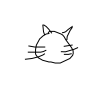

In [28]:
# get a sample drawing from the test set, and render it to .svg
stroke = test_set.random_sample()
draw_strokes(stroke)
# stroke[:,0:2] = stroke[:,0:2]
# img = stp(stroke)
# n_img = torch.unsqueeze(trans(img), dim=0)
# res = net(n_img)
# print(res)
# pred = res.data.max(1)[1].item()
# print(pred, res[0][pred])
# img

Let's try to encode the sample stroke into latent vector $z$

In [ ]:
print(len(stroke))
z = encode(stroke)

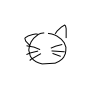

In [31]:
strokes = decode(z, temperature=0.7, class_id=54) # convert z back to drawing at temperature of 0.8

Create generated grid at various temperatures from 0.1 to 1.0

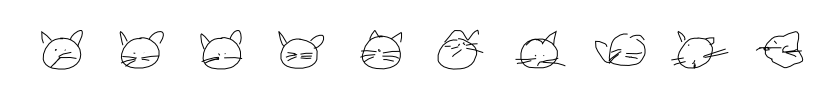

In [32]:
stroke_list = []
for i in range(10):
  stroke_list.append([decode(z, draw_mode=False, temperature=0.1*i+0.1), [0, i]])
stroke_grid = make_grid_svg(stroke_list)
draw_strokes(stroke_grid)

In [33]:
import os
import sys
import torch
import json
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

from Model.nets import resnet34, resnet18
from Model.nets import convnet

def load_model(model_path, model_type='resnet18', num_classes=345, in_channels=3, image_size=224, device='cpu'):
    """
    加载训练好的模型
    """
    # 根据模型类型创建模型实例
    if model_type == 'resnet34':
        model = resnet34(num_classes, pretrained=False, in_channels=in_channels, image_size=image_size)
    elif model_type == 'resnet18':
        model = resnet18(num_classes, pretrained=False, in_channels=in_channels, image_size=image_size)
    elif model_type == 'convnet':
        model = convnet(num_classes)
    else:
        raise ValueError(f"不支持的模型类型: {model_type}")
    
    # 加载模型权重
    checkpoint = torch.load(model_path, map_location=device)
    
    # 检查是否是完整checkpoint还是只有模型权重
    if 'model_state_dict' in checkpoint:
        model_weights = checkpoint['model_state_dict']
    else:
        model_weights = checkpoint
    
    # 加载权重（处理可能的DataParallel前缀）
    if list(model_weights.keys())[0].startswith('module.'):
        # 如果权重有'module.'前缀，但模型不是DataParallel，需要移除前缀
        from collections import OrderedDict
        new_state_dict = OrderedDict()
        for k, v in model_weights.items():
            name = k[7:] if k.startswith('module.') else k  # 移除'module.'前缀
            new_state_dict[name] = v
        model_weights = new_state_dict
    
    model.load_state_dict(model_weights)
    model = model.to(device)
    model.eval()  # 设置为评估模式
    
    print(f"模型加载成功: {model_path}")
    print(f"模型类型: {model_type}, 类别数: {num_classes}")
    
    return model

model_path = '../ResNet/res18-30-cosine/checkpoint_epoch_30.pth'
resnet = load_model(model_path)
# print(checkpoint['model_state_dict'])

模型加载成功: ../ResNet/res18-30-cosine/checkpoint_epoch_30.pth
模型类型: resnet18, 类别数: 345


In [34]:
import torchvision.transforms as transforms
from Utils import draw_three, off2abs
transform_list = [
        transforms.ToTensor(), transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])]
trans = transforms.Compose(transform_list)

In [ ]:
# n_img = torch.unsqueeze(trans(img), dim=0)
# res = net(n_img)
# strokes = np.load('/inspire/hdd/project/wuliqifa/yanjunchi-24040/hang/recon/QuickDraw414k/coordinate_files/test/cake/cake_20.npy',encoding='latin1', allow_pickle=True)
# seq = strokes[:, 0:3]
# seq = seq.astype('float32')
# print(seq.shape)
print(strokes)
strokes_n = convert_seq(strokes)
# print(strokes_n)
test(strokes_n, resnet)
# print(res)
# pred = res.data.max(1)[1].item()
# print(pred, res[0][pred])

In [ ]:
n_img = torch.unsqueeze(trans(img), dim=0)
res = net(n_img)
seq = np.load('/inspire/hdd/project/wuliqifa/yanjunchi-24040/hang/recon/QuickDraw414k/coordinate_files/test/cake/cake_20.npy',encoding='latin1', allow_pickle=True)
seq = seq[:, 0:3]
seq = seq.astype('float32')
print(seq)

In [59]:
def get_next(loader, batch_idx, bs):
    batch = []
    for idx in range(bs):
      i = bs * batch_idx + idx
      data = loader.strokes[i]
      data_copy = np.copy(data)
      batch.append(data_copy)
    return batch
acc_top1 = 0
acc_top5 = 0
cid = 67
trails = 50
for _ in range(5):
    for batch_idx in range(trails):
        stroke = get_next(test_set, batch_idx, 4)
        z = encode(stroke[0])
        seq_e = decode(z, temperature=0.1, class_id=54, draw_mode=False)
        seq_en = convert_seq(seq_e)
        ids, prob = test(seq_en, resnet)
        # print(ids)
        if ids[0] == cid:
            acc_top1 += 1
        if cid in ids:
            acc_top5 += 1
trails *= 5
acc_top1 /= (trails)
acc_top5 /= (trails)
print(acc_top1, acc_top5)

0.772 0.82


In [72]:
a = 75
ac = 75.15
at = (a - 1 + ac) / (2 * ac - 1)
at

0.9989953114534494

In [69]:
acc_top1 = 0
acc_top5 = 0
cid = 67
trails = 100
gt_ids = [52, 67, 261, 54, 119]
accs = [0, 0, 0, 0, 0]
for batch_idx in range(trails):
    seq_e = decode(temperature=0.1, class_id=67, draw_mode=False)
    seq_en = convert_seq(seq_e)
    ids, prob = test(seq_en, resnet)
    if ids[0] in gt_ids:
        acc_top1 += 1
    for id in ids:
        if id in gt_ids:
            acc_top5 += 1
            break
    for i in range(len(gt_ids)):
        if ids[0] == gt_ids[i]:
            accs[i] += 1
            break
acc_top1 /= (trails)
acc_top5 /= (trails)
accs = [x / trails for x in accs]
print(acc_top1, acc_top5, accs)

0.59 0.74 [0.16, 0.12, 0.11, 0.07, 0.13]


In [ ]:
import numpy as np

def stroke3_delta_to_abs_points(stroke3_delta: np.ndarray, reset_on_penup: bool = False) -> np.ndarray:
    """
    stroke3_delta: [N,3] where each row is [dx, dy, pen_up]
    返回 absolute points: [N,2]
    reset_on_penup:
      - False: 全程累加（更常见）
      - True: 每次 pen_up=1 后，下一个点从 (0,0) 重新开始累加（更像“分段独立”）
    """
    s = np.asarray(stroke3_delta)
    assert s.ndim == 2 and s.shape[1] >= 2
    dxdy = s[:, :2].astype(np.float64)

    abs_pts = np.zeros((len(dxdy), 2), dtype=np.float64)
    x, y = 0.0, 0.0

    if s.shape[1] >= 3:
        pen = s[:, 2].astype(np.int32)
    else:
        pen = np.zeros((len(dxdy),), dtype=np.int32)

    for i in range(len(dxdy)):
        x += dxdy[i, 0]
        y += dxdy[i, 1]
        abs_pts[i] = (x, y)

        if reset_on_penup and pen[i] == 1:
            x, y = 0.0, 0.0

    return abs_pts

def _resample_by_arclength(points: np.ndarray, m: int) -> np.ndarray:
    points = np.asarray(points, dtype=np.float64)
    n = len(points)
    if n == 0:
        return np.zeros((m, 2), dtype=np.float64)
    if n == 1:
        return np.repeat(points, m, axis=0)

    seg = points[1:] - points[:-1]
    seg_len = np.linalg.norm(seg, axis=1)
    cum = np.concatenate([[0.0], np.cumsum(seg_len)])
    total = cum[-1]

    if total < 1e-12:
        return np.repeat(points[:1], m, axis=0)

    target = np.linspace(0.0, total, m)
    out = np.zeros((m, 2), dtype=np.float64)

    j = 0
    for i, t in enumerate(target):
        while j < len(cum) - 1 and cum[j + 1] < t:
            j += 1
        if j == len(cum) - 1:
            out[i] = points[-1]
        else:
            t0, t1 = cum[j], cum[j + 1]
            alpha = 0.0 if (t1 - t0) < 1e-12 else (t - t0) / (t1 - t0)
            out[i] = (1 - alpha) * points[j] + alpha * points[j + 1]
    return out

def stroke_l2_distance_delta(
    stroke_a_delta: np.ndarray,
    stroke_b_delta: np.ndarray,
    num_samples: int = 128,
    align: str = "center",   # "none" | "start" | "center"
    reset_on_penup: bool = False,
    return_all: bool = False,
):
    """
    输入：两个 stroke-3 delta（[dx,dy,pen_up]）
    输出：mean_l2 / rmse / max_l2
    """
    pa = stroke3_delta_to_abs_points(stroke_a_delta, reset_on_penup=reset_on_penup)
    pb = stroke3_delta_to_abs_points(stroke_b_delta, reset_on_penup=reset_on_penup)

    ra = _resample_by_arclength(pa, num_samples)
    rb = _resample_by_arclength(pb, num_samples)

    if align == "start":
        ra = ra - ra[:1]
        rb = rb - rb[:1]
    elif align == "center":
        ra = ra - ra.mean(axis=0, keepdims=True)
        rb = rb - rb.mean(axis=0, keepdims=True)
    elif align == "none":
        pass
    else:
        raise ValueError("align must be one of: none/start/center")

    d = np.linalg.norm(ra - rb, axis=1)
    mean_l2 = float(d.mean())
    rmse = float(np.sqrt((d ** 2).mean()))
    max_l2 = float(d.max())

    if return_all:
        return {"mean_l2": mean_l2, "rmse": rmse, "max_l2": max_l2, "ra": ra, "rb": rb, "per_point": d}
    return {"mean_l2": mean_l2, "rmse": rmse, "max_l2": max_l2}

# print(stroke.shape, strokes.shape)
import numpy as np

# 初始化列表存储所有指标
mean_l2_list = []
rmse_list = []
max_l2_list = []

for i in range(100):
    stroke = get_next(test_set, i, 4)[0]
    z = encode(stroke)
    seq_e = decode(z, temperature=0.1, class_id=67, draw_mode=False)
    seq_en = convert_seq(seq_e)
    
    metrics = stroke_l2_distance_abs(stroke, seq_e, num_samples=128, align="center")
    print(f"第{i+1}次测试: mean_l2={metrics['mean_l2']:.4f}, rmse={metrics['rmse']:.4f}, max_l2={metrics['max_l2']:.4f}")
    
    # 收集指标
    mean_l2_list.append(metrics['mean_l2'])
    rmse_list.append(metrics['rmse'])
    max_l2_list.append(metrics['max_l2'])

# 转换为numpy数组以便计算统计量
mean_l2_arr = np.array(mean_l2_list)
rmse_arr = np.array(rmse_list)
max_l2_arr = np.array(max_l2_list)

# 计算统计量
avg_metrics = {
    'mean_l2': {
        'mean': np.mean(mean_l2_arr),
        'std': np.std(mean_l2_arr),
        'min': np.min(mean_l2_arr),
        'max': np.max(mean_l2_arr)
    },
    'rmse': {
        'mean': np.mean(rmse_arr),
        'std': np.std(rmse_arr),
        'min': np.min(rmse_arr),
        'max': np.max(rmse_arr)
    },
    'max_l2': {
        'mean': np.mean(max_l2_arr),
        'std': np.std(max_l2_arr),
        'min': np.min(max_l2_arr),
        'max': np.max(max_l2_arr)
    }
}

print("\n" + "="*60)
print("50次测试详细统计:")
print("-"*60)
print(f"mean_l2 - 平均值: {avg_metrics['mean_l2']['mean']:.6f}, 标准差: {avg_metrics['mean_l2']['std']:.6f}")
print(f"        最小值: {avg_metrics['mean_l2']['min']:.6f}, 最大值: {avg_metrics['mean_l2']['max']:.6f}")
print(f"rmse    - 平均值: {avg_metrics['rmse']['mean']:.6f}, 标准差: {avg_metrics['rmse']['std']:.6f}")
print(f"        最小值: {avg_metrics['rmse']['min']:.6f}, 最大值: {avg_metrics['rmse']['max']:.6f}")
print(f"max_l2  - 平均值: {avg_metrics['max_l2']['mean']:.6f}, 标准差: {avg_metrics['max_l2']['std']:.6f}")
print(f"        最小值: {avg_metrics['max_l2']['min']:.6f}, 最大值: {avg_metrics['max_l2']['max']:.6f}")
print("="*60)

In [ ]:
def dtw_distance(points_a: np.ndarray, points_b: np.ndarray) -> float:
    a = np.asarray(points_a, dtype=np.float64)
    b = np.asarray(points_b, dtype=np.float64)
    n, m = len(a), len(b)
    if n == 0 or m == 0:
        return float("inf")

    dp = np.full((n + 1, m + 1), np.inf, dtype=np.float64)
    dp[0, 0] = 0.0

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = np.linalg.norm(a[i - 1] - b[j - 1])
            dp[i, j] = cost + min(dp[i - 1, j], dp[i, j - 1], dp[i - 1, j - 1])

    return float(dp[n, m] / (n + m))  # 归一化，便于比较

def stroke_dtw_distance_delta(
    stroke_a_delta: np.ndarray,
    stroke_b_delta: np.ndarray,
    num_samples: int = 128,
    align: str = "center",
    reset_on_penup: bool = False,
) -> float:
    pa = stroke3_delta_to_abs_points(stroke_a_delta, reset_on_penup=reset_on_penup)
    pb = stroke3_delta_to_abs_points(stroke_b_delta, reset_on_penup=reset_on_penup)

    ra = _resample_by_arclength(pa, num_samples)
    rb = _resample_by_arclength(pb, num_samples)

    if align == "start":
        ra = ra - ra[:1]
        rb = rb - rb[:1]
    elif align == "center":
        ra = ra - ra.mean(axis=0, keepdims=True)
        rb = rb - rb.mean(axis=0, keepdims=True)
    elif align == "none":
        pass
    else:
        raise ValueError("align must be one of: none/start/center")

    return dtw_distance(ra, rb)

import numpy as np

# 初始化列表存储所有指标
mean_l2_list = []

for i in range(100):
    stroke = get_next(test_set, i, 4)[0]
    z = encode(stroke)
    seq_e = decode(z, temperature=0.1, class_id=67, draw_mode=False)
    seq_en = convert_seq(seq_e)
    
    metrics = stroke_dtw_distance_delta(stroke, seq_e, num_samples=128, align="center")
    print(f"第{i+1}次测试: mean_l2={metrics:.4f}")
    
    # 收集指标
    mean_l2_list.append(metrics)

# 转换为numpy数组以便计算统计量
mean_l2_arr = np.array(mean_l2_list)
rmse_arr = np.array(rmse_list)
max_l2_arr = np.array(max_l2_list)

# 计算统计量
avg_metrics = {
    'mean_l2': {
        'mean': np.mean(mean_l2_arr),
        'std': np.std(mean_l2_arr),
        'min': np.min(mean_l2_arr),
        'max': np.max(mean_l2_arr)
    },
}

print("\n" + "="*60)
print("50次测试详细统计:")
print("-"*60)
print(f"mean_l2 - 平均值: {avg_metrics['mean_l2']['mean']:.6f}, 标准差: {avg_metrics['mean_l2']['std']:.6f}")
print(f"        最小值: {avg_metrics['mean_l2']['min']:.6f}, 最大值: {avg_metrics['mean_l2']['max']:.6f}")
print("="*60)

In [ ]:
def chamfer_distance(points_a: np.ndarray, points_b: np.ndarray) -> float:
    a = np.asarray(points_a, dtype=np.float64)
    b = np.asarray(points_b, dtype=np.float64)
    if len(a) == 0 or len(b) == 0:
        return float("inf")

    diff = a[:, None, :] - b[None, :, :]
    dist2 = np.sum(diff * diff, axis=2)  # [N,M]
    a2b = np.min(dist2, axis=1).mean()
    b2a = np.min(dist2, axis=0).mean()
    return float(a2b + b2a)

def stroke_chamfer_distance_delta(
    stroke_a_delta: np.ndarray,
    stroke_b_delta: np.ndarray,
    num_samples: int = 128,
    align: str = "center",
    reset_on_penup: bool = False,
) -> float:
    pa = stroke3_delta_to_abs_points(stroke_a_delta, reset_on_penup=reset_on_penup)
    pb = stroke3_delta_to_abs_points(stroke_b_delta, reset_on_penup=reset_on_penup)

    ra = _resample_by_arclength(pa, num_samples)
    rb = _resample_by_arclength(pb, num_samples)

    if align == "start":
        ra = ra - ra[:1]
        rb = rb - rb[:1]
    elif align == "center":
        ra = ra - ra.mean(axis=0, keepdims=True)
        rb = rb - rb.mean(axis=0, keepdims=True)
    elif align == "none":
        pass
    else:
        raise ValueError("align must be one of: none/start/center")

    return chamfer_distance(ra, rb)
mean_l2_list = []

for t in range(10):
    for i in range(50):
        stroke = get_next(test_set, i, 4)[0]
        z = encode(stroke)
        seq_e = decode(z, temperature=0.1+t*0.1, class_id=67, draw_mode=False)
        seq_en = convert_seq(seq_e)

        metrics = stroke_chamfer_distance_delta(stroke, seq_e, num_samples=128, align="center")
        # print(f"第{i+1}次测试: mean_l2={metrics:.4f}")

        # 收集指标
        mean_l2_list.append(metrics)

    # 转换为numpy数组以便计算统计量
    mean_l2_arr = np.array(mean_l2_list)
    rmse_arr = np.array(rmse_list)
    max_l2_arr = np.array(max_l2_list)

    # 计算统计量
    avg_metrics = {
        'mean_l2': {
            'mean': np.mean(mean_l2_arr),
            'std': np.std(mean_l2_arr),
            'min': np.min(mean_l2_arr),
            'max': np.max(mean_l2_arr)
        },
    }
    print(f'温度: {0.1+t*0.1}')
    print(f"平均值: {avg_metrics['mean_l2']['mean']:.6f}, 标准差: {avg_metrics['mean_l2']['std']:.6f}")
    print(f"最小值: {avg_metrics['mean_l2']['min']:.6f}, 最大值: {avg_metrics['mean_l2']['max']:.6f}")


In [ ]:
def diversity_fidelity_for_one_input(
    stroke_delta,
    encode_fn,
    decode_fn,
    stroke_distance_fn,     # e.g. stroke_chamfer_distance_delta
    class_id,
    num_samples=8,
    temperatures=None,      # list[float] or None -> 全用同一个 0.2
    num_resample_points=128,
    align="center",
    reset_on_penup=False,
    rng_seed=0,
    decode_kwargs=None,
):
    if decode_kwargs is None:
        decode_kwargs = {}

    # 1) 得到基准 latent
    z0 = np.asarray(encode_fn(stroke_delta)).reshape(-1)

    # 2) 采样生成多个重建
    if temperatures is None:
        temperatures = [0.2] * num_samples
    else:
        assert len(temperatures) == num_samples

    # 让每次 decode 有可控随机性（如果你的 decode 内部用 np.random）
    rng = np.random.default_rng(rng_seed)

    gens = []
    fidelities = []

    for k in range(num_samples):
        # 可选：如果 decode 里依赖 np.random，全局 seed 可以这样做（粗暴但常用）
        np.random.seed(int(rng.integers(0, 2**31-1)))

        seq_k = decode_fn(
            z0,
            temperature=float(temperatures[k]),
            class_id=int(class_id),
            draw_mode=False,
            **decode_kwargs,
        )
        gens.append(seq_k)

        fid = stroke_distance_fn(
            stroke_delta, seq_k,
            num_samples=num_resample_points,
            align=align,
            reset_on_penup=reset_on_penup
        )
        # 兼容你 distance_fn 返回 dict 或 float
        if isinstance(fid, dict):
            # chamfer那版如果你返回 float 就不会走这里
            fid_val = float(fid.get("mean_l2", fid.get("rmse", list(fid.values())[0])))
        else:
            fid_val = float(fid)
        fidelities.append(fid_val)

    # 3) diversity：样本间两两平均距离
    pair_dists = []
    for i in range(num_samples):
        for j in range(i + 1, num_samples):
            dij = stroke_distance_fn(
                gens[i], gens[j],
                num_samples=num_resample_points,
                align=align,
                reset_on_penup=reset_on_penup
            )
            pair_dists.append(float(dij) if not isinstance(dij, dict) else float(list(dij.values())[0]))

    diversity = float(np.mean(pair_dists)) if pair_dists else 0.0
    fidelity = float(np.mean(fidelities))

    return {
        "diversity": diversity,
        "fidelity": fidelity,
        "fidelities": np.array(fidelities, dtype=np.float64),
        "pairwise": np.array(pair_dists, dtype=np.float64),
        "gens": gens,
        "z0": z0,
    }
import matplotlib.pyplot as plt

def diversity_fidelity_scatter(
    strokes_list,           # list of stroke-3 delta
    encode_fn,
    decode_fn,
    stroke_distance_fn,     # e.g. stroke_chamfer_distance_delta
    class_id,
    num_samples_per_input=8,
    temperature_base=0.1,
    temperature_step=0.05,
    num_resample_points=128,
    align="center",
    reset_on_penup=False,
    decode_kwargs=None,
):
    if decode_kwargs is None:
        decode_kwargs = {}

    xs = []
    ys = []
    per_item = []

    for idx, stroke in enumerate(strokes_list):
        temps = [temperature_base + k * temperature_step for k in range(num_samples_per_input)]
        out = diversity_fidelity_for_one_input(
            stroke_delta=stroke,
            encode_fn=encode_fn,
            decode_fn=decode_fn,
            stroke_distance_fn=stroke_distance_fn,
            class_id=class_id,
            num_samples=num_samples_per_input,
            temperatures=temps,
            num_resample_points=num_resample_points,
            align=align,
            reset_on_penup=reset_on_penup,
            rng_seed=idx,
            decode_kwargs=decode_kwargs,
        )
        xs.append(out["fidelity"])
        ys.append(out["diversity"])
        per_item.append(out)

    xs = np.array(xs, dtype=np.float64)
    ys = np.array(ys, dtype=np.float64)

    plt.figure()
    plt.scatter(xs, ys)
    plt.xlabel("Fidelity")
    plt.ylabel("Diversity")
    plt.title(f"Diversity vs Fidelity")
    plt.grid(True)
    plt.savefig('scatter.png', dpi=600)
    plt.show()

    return {"fidelity": xs, "diversity": ys, "details": per_item}
out = diversity_fidelity_for_one_input(
    stroke_delta=stroke,
    encode_fn=encode,
    decode_fn=decode,
    stroke_distance_fn=stroke_chamfer_distance_delta,
    class_id=67,
    num_samples=8,
    temperatures=[0.1 + 0.05*k for k in range(8)],
)

print("fidelity:", out["fidelity"], "diversity:", out["diversity"])
strokes_list = [get_next(test_set, i, 4)[0] for i in range(30)]
div_fid = diversity_fidelity_scatter(
    strokes_list=strokes_list,
    encode_fn=encode,
    decode_fn=decode,
    stroke_distance_fn=stroke_chamfer_distance_delta,
    class_id=67,
    num_samples_per_input=8,
    temperature_base=0.1,
    temperature_step=0.05,
)


In [ ]:
def diversity_fidelity_scatter2(
    stroke,           # list of stroke-3 delta
    encode_fn,
    decode_fn,
    stroke_distance_fn,     # e.g. stroke_chamfer_distance_delta
    class_id,
    num_samples_per_input=8,
    temps_in = [],
    num_resample_points=128,
    align="center",
    reset_on_penup=False,
    decode_kwargs=None,
):
    if decode_kwargs is None:
        decode_kwargs = {}

    xs = []
    ys = []
    per_item = []

    for temp in temps_in:
        temps = [temp] * 8
        out = diversity_fidelity_for_one_input(
            stroke_delta=stroke,
            encode_fn=encode_fn,
            decode_fn=decode_fn,
            stroke_distance_fn=stroke_distance_fn,
            class_id=class_id,
            num_samples=num_samples_per_input,
            temperatures=temps,
            num_resample_points=num_resample_points,
            align=align,
            reset_on_penup=reset_on_penup,
            rng_seed=42,
            decode_kwargs=decode_kwargs,
        )
        xs.append(out["fidelity"])
        ys.append(out["diversity"])
        per_item.append(out)

    xs = np.array(xs, dtype=np.float64)
    ys = np.array(ys, dtype=np.float64)

    plt.figure()
    plt.scatter(xs, ys)
    plt.xlabel("Fidelity")
    plt.ylabel("Diversity")
    plt.title(f"Diversity vs Fidelity")
    plt.grid(True)
    plt.savefig('scatter2.png', dpi=600)
    plt.show()

    return {"fidelity": xs, "diversity": ys, "details": per_item}
iv_fid = diversity_fidelity_scatter2(
    stroke=stroke,
    encode_fn=encode,
    decode_fn=decode,
    stroke_distance_fn=stroke_chamfer_distance_delta,
    class_id=67,
    num_samples_per_input=8,
    temps_in = [0.1 + 0.05*t for t in range(20)]
)

print("fidelity:", out["fidelity"], "diversity:", out["diversity"])

In [ ]:
sti = json.load(open('cls_map.json', 'r'))
its = dict({v:k for k,v in sti.items()})
json.dump(its, open('cls_map_i2s.json', 'w'))

Latent Space Interpolation Example between $z_0$ and $z_1$

In [ ]:
# get a sample drawing from the test set, and render it to .svg
z0 = z
_ = decode(z0)

In [ ]:
stroke = test_set.random_sample()
z1 = encode(stroke)
_ = decode(z1)

Now we interpolate between sheep $z_0$ and sheep $z_1$

In [ ]:
z_list = [] # interpolate spherically between z0 and z1
N = 10
for t in np.linspace(0, 1, N):
  z_list.append(slerp(z0, z1, t))

In [ ]:
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
  reconstructions.append([decode(z_list[i], draw_mode=False), [0, i]])

In [ ]:
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

Let's load the Flamingo Model, and try Unconditional (Decoder-Only) Generation

In [ ]:
model_dir = '/tmp/sketch_rnn/models/flamingo/lstm_uncond'

In [ ]:
[hps_model, eval_hps_model, sample_hps_model] = load_model_compatible(model_dir)

In [ ]:
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)

In [ ]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [ ]:
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

In [ ]:
# randomly unconditionally generate 10 examples
N = 10
reconstructions = []
for i in range(N):
  reconstructions.append([decode(temperature=0.5, draw_mode=False, class_id=52), [0, i]])
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

In [ ]:
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

Let's load the owl model, and generate two sketches using two random IID gaussian latent vectors

In [ ]:
model_dir = '/tmp/sketch_rnn/models/owl/lstm'

In [ ]:
[hps_model, eval_hps_model, sample_hps_model] = load_model_compatible(model_dir)
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

In [ ]:
z_0 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_0)

In [ ]:
z_1 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_1)

Let's interpolate between the two owls $z_0$ and $z_1$

In [ ]:
z_list = [] # interpolate spherically between z_0 and z_1
N = 10
for t in np.linspace(0, 1, N):
  z_list.append(slerp(z_0, z_1, t))
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
  reconstructions.append([decode(z_list[i], draw_mode=False, temperature=0.1), [0, i]])

In [ ]:
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

Let's load the model trained on both cats and buses!  catbus!

In [ ]:
model_dir = '/tmp/sketch_rnn/models/catbus/lstm'

In [ ]:
[hps_model, eval_hps_model, sample_hps_model] = load_model_compatible(model_dir)
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

In [ ]:
z_1 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_1)

In [ ]:
z_0 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_0)

Let's interpolate between a cat and a bus!!!

In [ ]:
z_list = [] # interpolate spherically between z_1 and z_0
N = 10
for t in np.linspace(0, 1, N):
  z_list.append(slerp(z_1, z_0, t))
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
  reconstructions.append([decode(z_list[i], draw_mode=False, temperature=0.15), [0, i]])

In [ ]:
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

Why stop here? Let's load the model trained on both elephants and pigs!!!

In [ ]:
model_dir = '/tmp/sketch_rnn/models/elephantpig/lstm'

In [ ]:
[hps_model, eval_hps_model, sample_hps_model] = load_model_compatible(model_dir)
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

In [ ]:
z_0 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_0)

In [ ]:
z_1 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_1)

Tribute to an episode of [South Park](https://en.wikipedia.org/wiki/An_Elephant_Makes_Love_to_a_Pig): The interpolation between an Elephant and a Pig

In [ ]:
z_list = [] # interpolate spherically between z_1 and z_0
N = 10
for t in np.linspace(0, 1, N):
  z_list.append(slerp(z_0, z_1, t))
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
  reconstructions.append([decode(z_list[i], draw_mode=False, temperature=0.15), [0, i]])

In [ ]:
stroke_grid = make_grid_svg(reconstructions, grid_space_x=25.0)

In [ ]:
draw_strokes(stroke_grid, factor=0.3)